## Дипломный проект на курсе Data Science школа SkillFactory
# «Модель прогнозирования стоимости жилья для агентства недвижимости»

**Цель:** разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

**Поставленные задачи:**
1. Провести разведывательный анализ и очистку исходных данных. Обратите внимание, что данные в таблице реальные: в результате во многих признаках присутствуют дублирующиеся категории, ошибки ввода, жаргонные сокращения и т .д. Вам предстоит отыскать закономерности, самостоятельно расшифровать все сокращения, найти синонимы в данных, обработать пропуски и удалить выбросы. 
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

**Описание данных:**<br>
<br>
➔ 'status' — статус продажи;<br>
➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;<br>
➔ 'propertyType' — тип объекта недвижимости;<br>
➔ 'street' — адрес объекта;<br>
➔ 'baths' — количество ванных комнат;<br>
➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);<br>
➔ 'fireplace' — наличие камина;<br>
➔ 'city' — город;<br>
➔ 'schools' — сведения о школах в районе;<br>
➔ 'sqft' — площадь в футах;<br>
➔ 'zipcode' — почтовый индекс;<br>
➔ 'beds' — количество спален;<br>
➔ 'state' — штат;<br>
➔ 'stories' — количество этажей;<br>
➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);<br><br>

➔ **'target'** — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [40]:
import numpy as np 
import pandas as pd

# подключаем необходимые библиотеки
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.subplots as spimport
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# внешняя функция для поиска выбросов
from outliers_lib.find_outliers import find_outliers_iqr

In [41]:
# зафиусируем RANDOM_SEED
RANDOM_SEED = 45

In [42]:
# зафиксируем версию пакетов
!pip freeze > requirements.txt

## 2. Разведывательный анализ (EDA) и преобразование данных

In [43]:
# Подгрузим нашу базу данных
df = pd.read_csv(r'D:\Diplom\cleaned_data.csv')
df.head(8)

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_all,beds_all,school_distance_min,Year built,Remodeled year_final,Heating_final
0,Active,single family,240 Heather Ln,3.5,Southern Pines,2900,28387,NC,418000,False,4.0,2.70,2019,False,True
1,For sale,single family,12911 E Heroy Ave,3.0,Spokane Valley,1947,99216,WA,310000,False,3.0,1.01,2019,False,False
2,For sale,single family,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,3.0,1.19,1961,True,True
3,For sale,single family,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,5.0,0.10,2006,True,True
4,For sale,land,1524 Kiscoe St,0.0,Palm Bay,0,32908,FL,5000,False,0.0,3.03,unknown,False,False
5,For sale,townhouse,1624 S Newkirk St,0.0,Philadelphia,897,19145,PA,209000,False,2.0,-1.00,1920,False,True
6,Active,other,552 Casanova Ct,0.0,POINCIANA,1507,34759,FL,181500,False,0.0,0.80,2006,True,True
7,Active,other,6094 Mingle Dr,0.0,Memphis,0,38115,TN,68000,False,0.0,0.40,1976,False,False


In [44]:
# Немного информации о нашей БД
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374249 entries, 0 to 374248
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                374249 non-null  object 
 1   propertyType          374249 non-null  object 
 2   street                374249 non-null  object 
 3   baths                 374249 non-null  float64
 4   city                  374249 non-null  object 
 5   sqft                  374249 non-null  int64  
 6   zipcode               374249 non-null  int64  
 7   state                 374249 non-null  object 
 8   target                374249 non-null  int64  
 9   private_pool_all      374249 non-null  bool   
 10  beds_all              374249 non-null  float64
 11  school_distance_min   374249 non-null  float64
 12  Year built            374249 non-null  object 
 13  Remodeled year_final  374249 non-null  bool   
 14  Heating_final         374249 non-null  bool   
dtype

### 2.1 Анализ числовых данных и проверка выбросов.

В числовые данные у нас попал признак zipcode, который на самом деле является категориальным.

In [45]:
# изменим тип столбца zipcode
df['zipcode'] = df['zipcode'].astype(str)
df.describe()

,baths,sqft,target,beds_all,school_distance_min
count,374249.000000,3.742490e+05,3.742490e+05,374249.000000,374249.000000
mean,2.337149,6.557172e+03,6.452504e+05,2.365513,1.200335
std,18.907441,1.501014e+06,1.839708e+06,2.078903,5.424609
min,0.000000,0.000000e+00,1.000000e+00,0.000000,-1.000000
25%,0.000000,1.056000e+03,1.879000e+05,0.000000,0.340000
50%,2.000000,1.677000e+03,3.200000e+05,3.000000,0.670000
75%,3.000000,2.495000e+03,5.845000e+05,4.000000,1.300000
max,750.000000,7.959794e+08,1.950000e+08,144.000000,1590.380000


Из выгруженных данных можно выделить максимальные и минимальные значения таких столбцов как площадь, количество спален, количество ванных комнат, таргет.

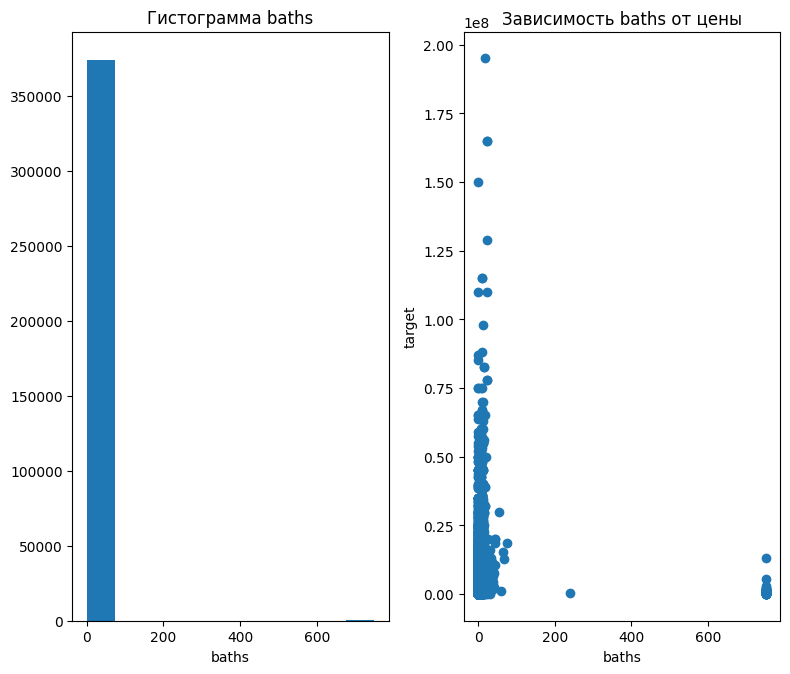

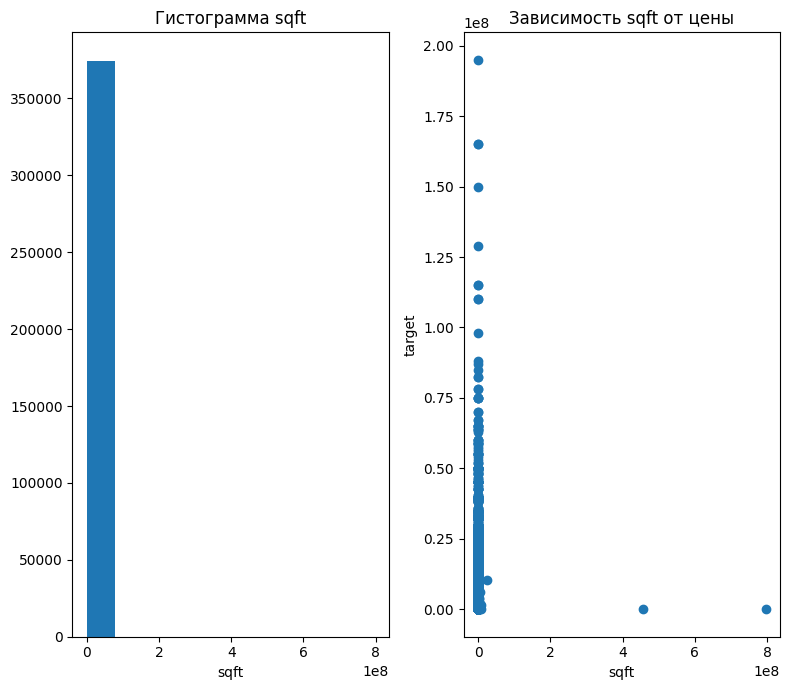

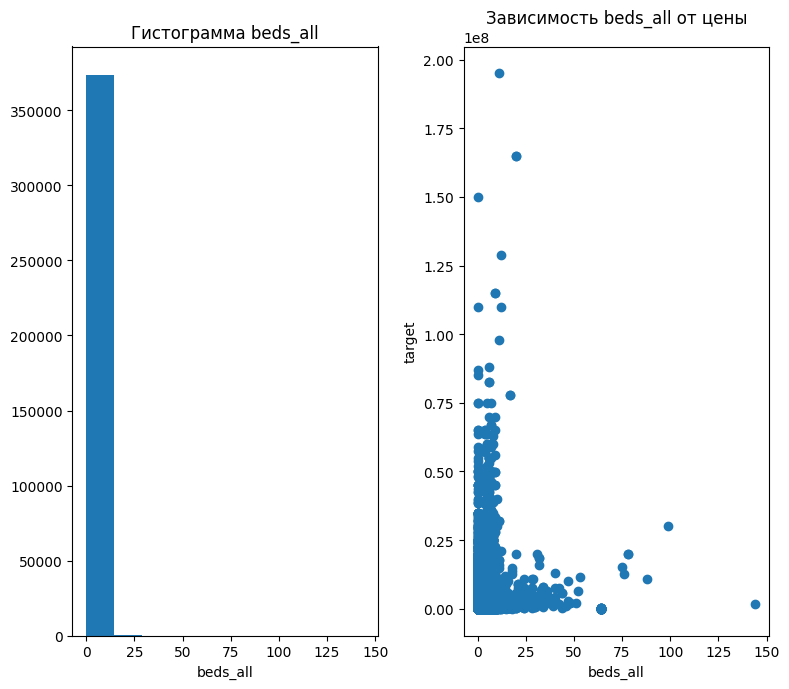

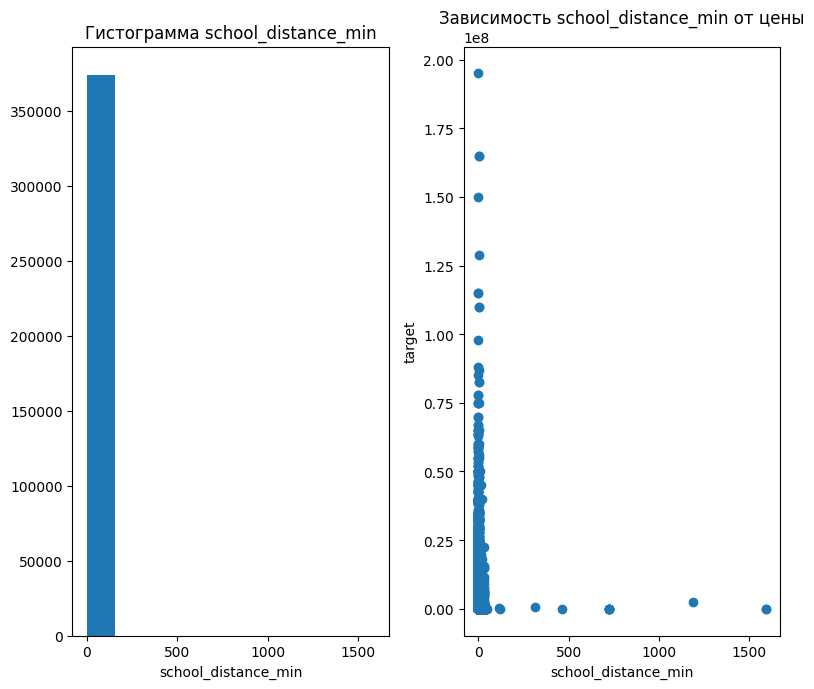

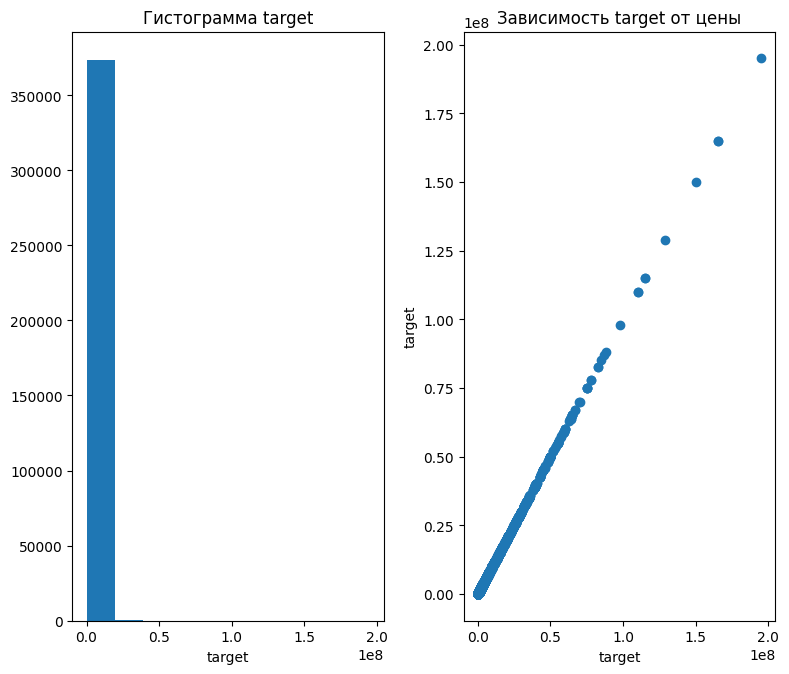

In [46]:
# Соберем все числовые признаки в единый список:
num_features = ['baths', 'sqft', 'beds_all', 'school_distance_min', 'target']

# Создадим папку для хранения графиков
output_directory = 'graphics'
os.makedirs(output_directory, exist_ok=True)

# Построим гистограммы и график рассеивания для числовых признаков с таргетом
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.hist(df[feature])
    ax1.set_xlabel(feature)
    ax1.set_title(f'Гистограмма {feature}')
 
    ax2.scatter(data=df, x=feature, y='target')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'Зависимость {feature} от цены')
    
    plt.tight_layout()

    image_filename = os.path.join(output_directory, f'1_{feature}_plot.png')
    fig.savefig(image_filename)

Произведем анализ каждого из графиков.<br>

### Данные столбца baths
Из графика по количеству ванных комнат видно, что имеются очень большие значения не соответствующие реальности и цена за эти объекты слишком низкая. Примем значение 100 за выбросы и удалим их. Однако еще остается много объектов с большим количеством ванных комнат. Построим график коробка с усами и убедимся, что много выбросов больше 8-ми. Уточним эти выбросы методом Тьюки и удалим их.<br>

In [47]:
# Уберем данные с выбросами из столбца
condition_1 = df['baths'] > 100
df.drop(df[condition_1].index, inplace=True)

Дополнительно построим график коробка с усами, чтоб увидеть выбросы.

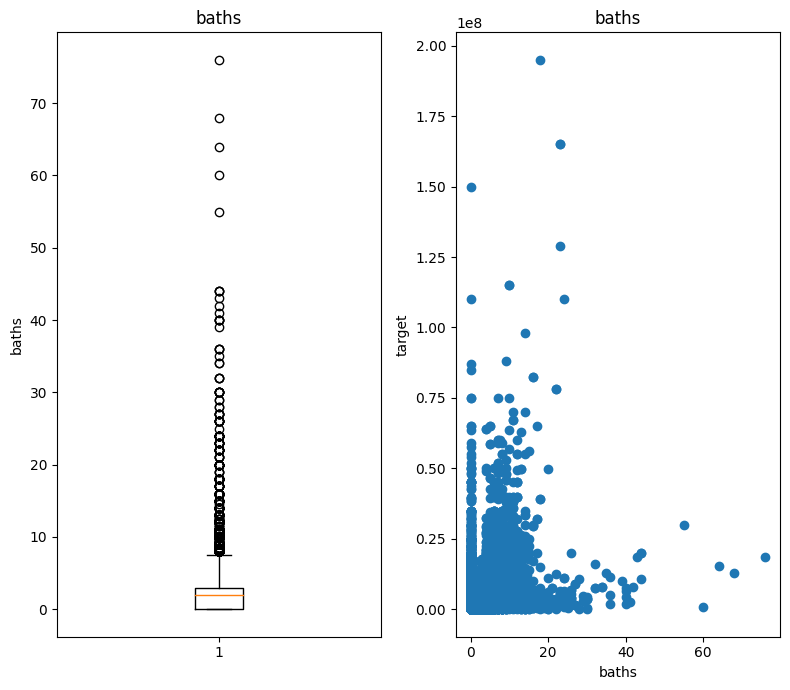

In [48]:
# График после чистки выбросов
num_features_1 = ['baths']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.scatter(data=df, x=feature, y='target')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

Применим метод межквартильного размаха для нахождения и удалим найденные выбросы.

In [49]:
# Применим функцию из отдельного файла для нахождения выбросов
outliers1, cleaned1 = find_outliers_iqr(df, 'baths', left=2, right=2, log_scale=False)
print(f'Количество выбросов по методу Тьюки: {outliers1.shape[0]}')
print(f'Всего записей: {cleaned1.shape[0]}')

# Удалим выбросы
df = df.drop(outliers1.index)

Количество выбросов по методу Тьюки: 1022
Всего записей: 372445


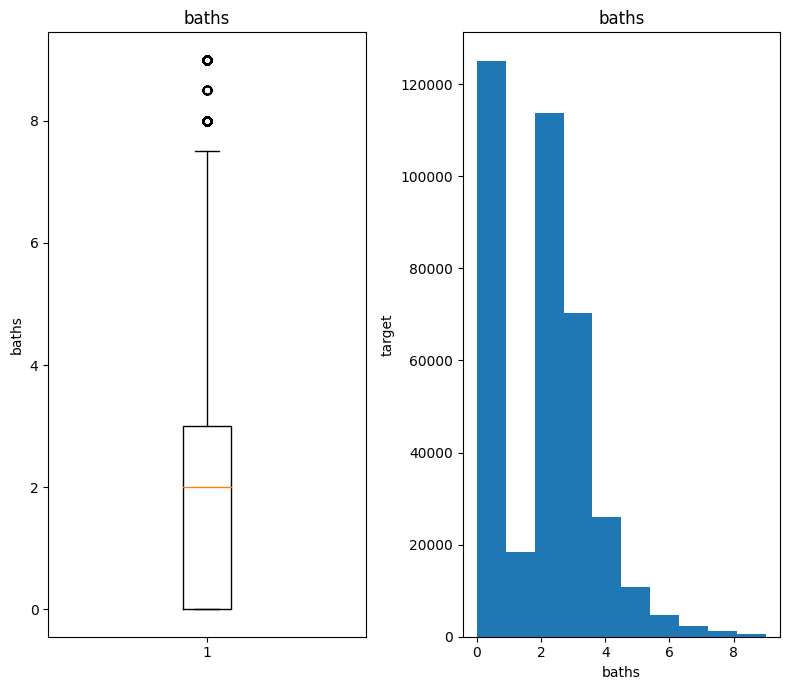

In [50]:
# Построим графики после очередной чистки выбросов
num_features_1 = ['baths']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='baths')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'3_{feature}_plot.png')
    fig.savefig(image_filename)

### Данные столбца sqft
Из графика площади видно, что есть объекты с очень большой площадью, но при этом их цена низкая. Принимаем эти значения за выбросы и удаляем их. Однако и  нулевая площадь будет давать неточности в предсказания модели, так как площадь является основным показателем стоимости недвижимости. Удалим их. Видем, что распределение признака не нормальное, очистим данные от выбросов по методу Тьюки с логарифмированием.<br>

In [51]:
# Просмотрим явные выбросы в столбце (площадь более 1 000 000 футов квадратных)
condition_2 = df['sqft'] > 1000000
display(df[condition_2])

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_all,beds_all,school_distance_min,Year built,Remodeled year_final,Heating_final
4561,For sale,land,State Highway 30,0.0,College Station,1043741,77845,TX,1200000,False,0.0,2.35,unknown,False,False
10709,unknown,other,Lane Dr,0.0,San Antonio,2746458,78263,TX,900000,False,0.0,1.40,unknown,False,False
37116,For sale,land,23114 Henness Pass,0.0,San Antonio,2585006,78255,TX,138000,False,0.0,2.62,unknown,False,True
39356,unknown,other,7193 Talley Rd,0.0,San Antonio,1611720,78253,TX,1300000,False,0.0,4.70,unknown,False,False
51826,For sale,land,22462 Morin Rd,0.0,Von Ormy,4356000,78073,TX,2000000,False,0.0,4.22,unknown,False,False
62273,For sale,single family,1723 Pulte St,2.0,Cincinnati,795979430,45225,OH,27500,False,2.0,0.78,1901,False,True
73647,For sale,land,Out Of Area,0.0,Laredo,7078574,78041,TX,98000,False,0.0,2.53,unknown,False,False
76095,unknown,other,914 E Braker Ln,0.0,Austin,1655280,78753,TX,6200000,False,0.0,0.30,unknown,False,False
81839,For sale,land,Fanning Bayou Dr,0.0,Panama City,1598652,32409,FL,2500000,False,0.0,1.85,unknown,False,False
89116,unknown,other,S Ivey Ln,0.0,Orlando,1366477,32805,FL,170000,False,0.0,0.50,unknown,False,False


In [52]:
# Удаляем эти выбросы
df.drop(df[condition_2].index, inplace=True)

# Посмотрим на строки с нулевой площадью
condition_3 = df['sqft'] == 0
df_3 = df[condition_3]
display(df_3)

# Удалим их
df.drop(df[condition_3].index, inplace=True)

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_all,beds_all,school_distance_min,Year built,Remodeled year_final,Heating_final
4,For sale,land,1524 Kiscoe St,0.0,Palm Bay,0,32908,FL,5000,False,0.0,3.03,unknown,False,False
7,Active,other,6094 Mingle Dr,0.0,Memphis,0,38115,TN,68000,False,0.0,0.40,1976,False,False
15,For sale,other,930 52nd St,0.0,Brooklyn,0,11219,NY,1650000,False,0.0,0.20,1905,True,False
26,Active,other,5755 SW 123 Ave,0.0,Miami,0,33183,FL,799000,False,0.0,0.90,unknown,False,False
40,Active,other,1104 Rotonda Cir,0.0,ROTONDA WEST,0,33947,FL,54000,False,0.0,3.10,unknown,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374204,For sale,land,6383 Cathedral Dr,0.0,Hickory,0,28601,NC,41000,False,0.0,4.48,unknown,False,False
374205,Active,other,Mantova Ct,0.0,ORLANDO,0,32836,FL,400000,False,0.0,1.30,unknown,False,False
374210,For sale,single family,206/208 N Randolph St,0.0,Indianapolis,0,46201,IN,50000,False,0.0,0.43,1910,False,False
374218,Active,other,2104 Russell Ave,0.0,Charlotte,0,28216,NC,99990,False,0.0,0.70,unknown,False,False


Значения в столбце не являются нормально-распределенными или симметричным. Логарифмируем признак.

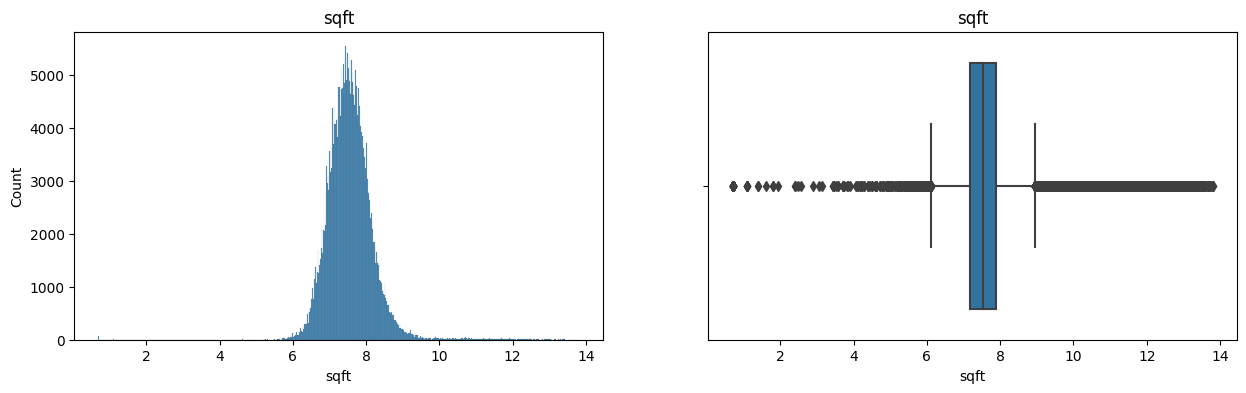

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x=np.log(df['sqft']+1), ax=axes[0])
histplot.set_title('sqft')
boxplot = sns.boxplot(data=df, x=np.log(df['sqft']+1), ax=axes[1])
boxplot.set_title('sqft')

# сохраним график
fig.savefig('graphics/2_sqft.png') 

При помощи логарифмирования нам удалось добиться некоторой симметрии данных. <br> Применим метод межквартильного размаха с предварительным логарифмированием и 2-мя размахами в левую и правую сторону распределения. 

Количество выбросов по методу Тьюки: 4070
Всего записей: 318970


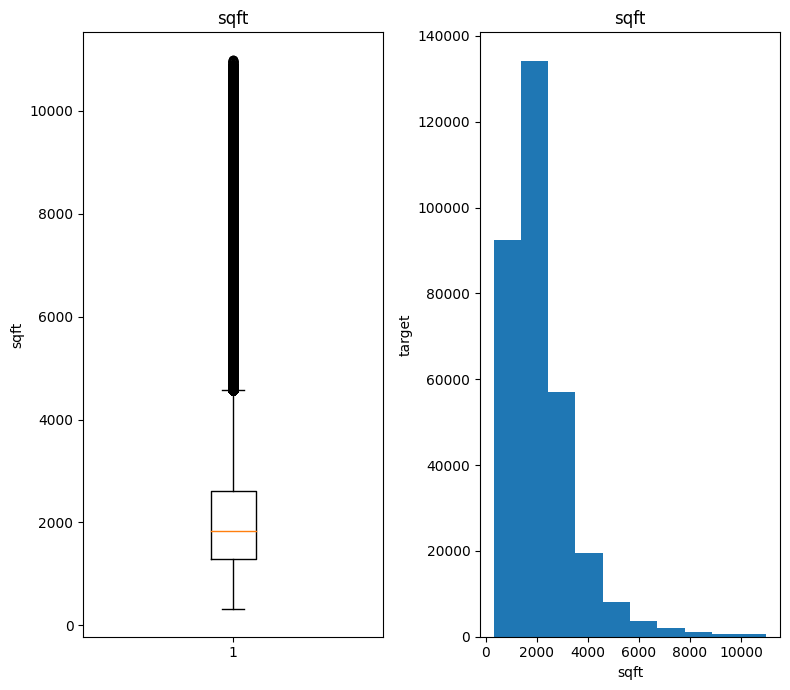

In [54]:

outliers2, cleaned2 = find_outliers_iqr(df, 'sqft', left=2, right=2, log_scale=True)
print(f'Количество выбросов по методу Тьюки: {outliers2.shape[0]}')
print(f'Всего записей: {cleaned2.shape[0]}')

# Удалим эти выбросы
df = df.drop(outliers2.index)

# Построим новые графики
num_features_1 = ['sqft']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='sqft')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'4_{feature}_plot.png')
    fig.savefig(image_filename)

### Данные по столбцу school_distance_min
Из графика расстояния до школы видим, что есть явные выбросы. Очистим данные от выбросов по методу Тьюки.<br><br>

Число выбросов по методу Тьюки: 18993
Результирующее число записей: 299937


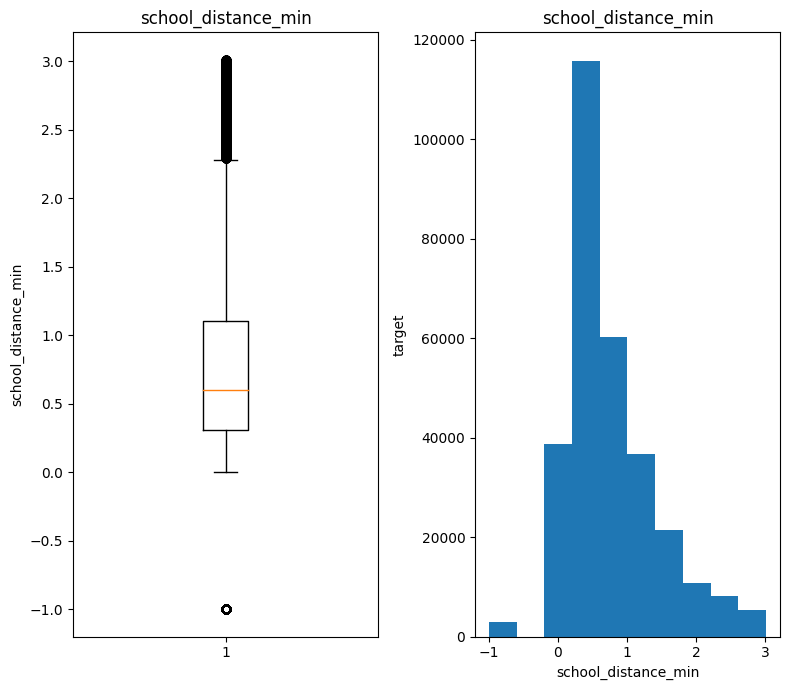

In [55]:
# Применяем функцию  из отдельного файла для нахождения выбросов
outliers3, cleaned3 = find_outliers_iqr(df, 'school_distance_min', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers3.shape[0]}')
print(f'Результирующее число записей: {cleaned3.shape[0]}')

# Удаляем эти выбросы
df = df.drop(outliers3.index)

# Построим график после чистки от выбросов
num_features_1 = ['school_distance_min']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='school_distance_min')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

### Данные по столбцу beds_all
Из графика спалень видно, что есть явные выбросы. Очистим данные от выбросов по методу Тьюки.<br>

In [56]:
# Посмотрим на явные выбросы в столбце
condition_4 = df['beds_all'] > 10
df_4 = df[condition_4]
df_4

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_all,beds_all,school_distance_min,Year built,Remodeled year_final,Heating_final
136,For sale,multi family,2007 Clyde Ave,6.0,Los Angeles,4368,90016,CA,1700000,False,12.0,1.49,1955,False,True
255,For sale,multi family,4059 Allendale Ave,8.0,Oakland,5225,94619,CA,2100000,False,14.0,0.50,1968,False,True
2703,For sale,multi family,306 Harman St,6.0,Brooklyn,4130,11237,NY,1549000,False,12.0,0.07,1931,False,False
2797,For sale,condo,1723 Menahan St #6,6.0,Ridgewood,2500,11385,NY,1300000,False,12.0,0.03,1930,False,False
4366,For sale,multi family,6628 Beck Ave,6.0,North Hollywood,4440,91606,CA,1500000,False,12.0,0.52,1964,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369370,For sale,multi family,15919 Vanowen St,9.0,Van Nuys,6450,91406,CA,1770000,False,12.0,0.24,1962,False,True
369446,Active,multi family,1140 Echo Park Ave,7.0,Los Angeles,3874,90026,CA,2599000,False,11.0,0.20,1988,False,False
373364,For sale,multi family,1551 N Avalon Blvd,8.0,Wilmington,5900,90744,CA,1350000,False,14.0,0.19,1963,False,False
373562,For sale,multi family,645 Vermont St,5.0,Brooklyn,4340,11207,NY,1490000,False,14.0,0.11,1930,False,True


In [57]:
# Удаляем строки с явными выбросами
df.drop(df[condition_4].index, inplace=True)

Снова применим метод межквартильного размаха для обнаружения и удаления выбросов.

In [58]:
# Применяем функцию из отдельного файла для нахождения выбросов 
outliers4, cleaned4 = find_outliers_iqr(df, 'beds_all', left=2, right=2, log_scale=False)
print(f'Количество выбросов по методу Тьюки: {outliers4.shape[0]}')
print(f'Всего записей: {cleaned4.shape[0]}')

# Удаляем эти выбросы
df = df.drop(outliers4.index)

Количество выбросов по методу Тьюки: 559
Всего записей: 298091


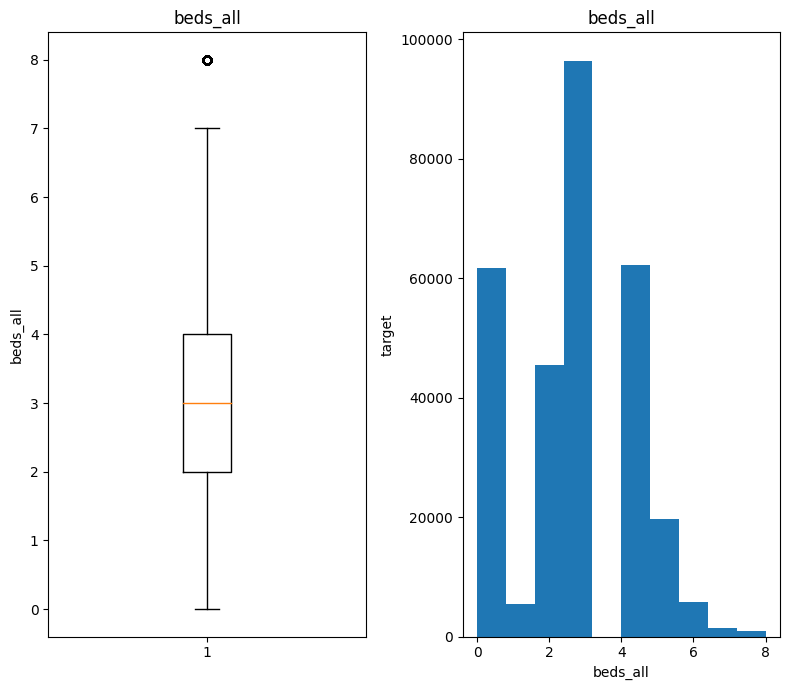

In [59]:
# Построим графики после удаления выбросов
num_features_1 = ['beds_all']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='beds_all')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # Сохраняем график
    image_filename = os.path.join(output_directory, f'3_{feature}_plot.png')
    fig.savefig(image_filename)

### Данные по столбцу target
Из графика target видно, что есть явные выбросы. Примем цену меньше 1000 за явные выбросы и удалим эти строки. 

In [60]:
# Уберем явно низкую цену
df = df.drop(df[df['target'] < 1000].index)

Для очистки данных от выбросов несоответствия цены и площади воспользуемся методом Тьюки.

In [61]:
# Применяем функцию из отдельного файла для нахождения выбросов
outliers_tg, cleaned_tg = find_outliers_iqr(df, 'target', left=3, right=3, log_scale=False)
print(f'Количество выбросов по методу Тьюки: {outliers_tg.shape[0]}')
print(f'Всего записей: {cleaned_tg.shape[0]}')

# Удаляем эти строки
df = df.drop(outliers_tg.index)

Количество выбросов по методу Тьюки: 15436
Всего записей: 283618


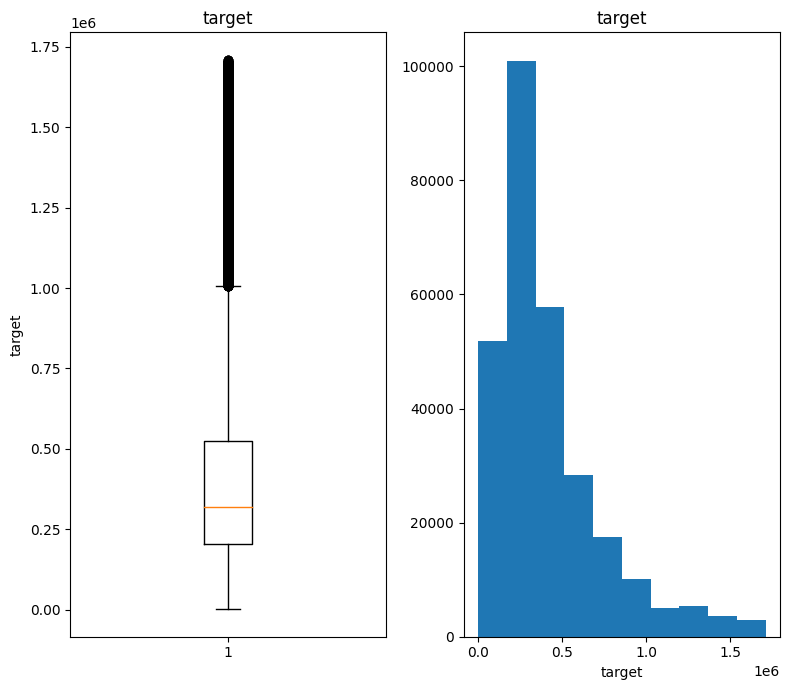

In [62]:
# Построим графики после чистки от выбросов
num_features_1 = ['target']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='target')
    ax2.set_xlabel(feature)
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

### 2.2 Анализ категориальных признаков

In [63]:
# Создадим список категоричальных признаков:
categor_features = ['status', 'propertyType', 'street', 'zipcode', 'state', 'city', 'Year built']
df.describe(include = 'object')

,status,propertyType,street,city,zipcode,state,Year built
count,283620,283620,283620,283620,283620,283620,283620
unique,13,11,252821,1641,3973,36,212
top,For sale,single family,Address Not Disclosed,Houston,33131,FL,2019
freq,160157,165857,552,21157,1391,82657,26824


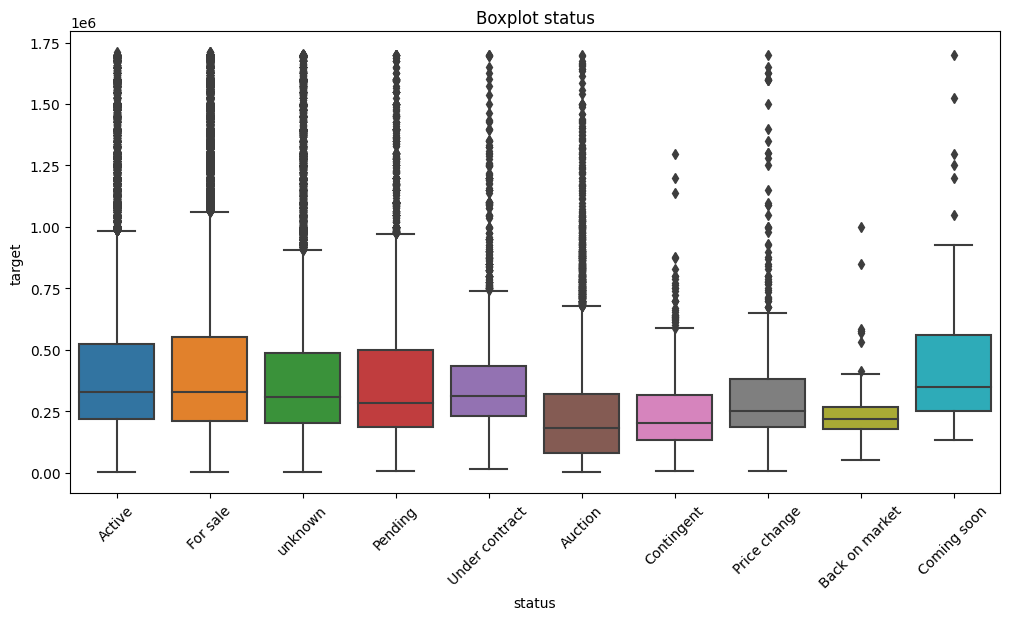

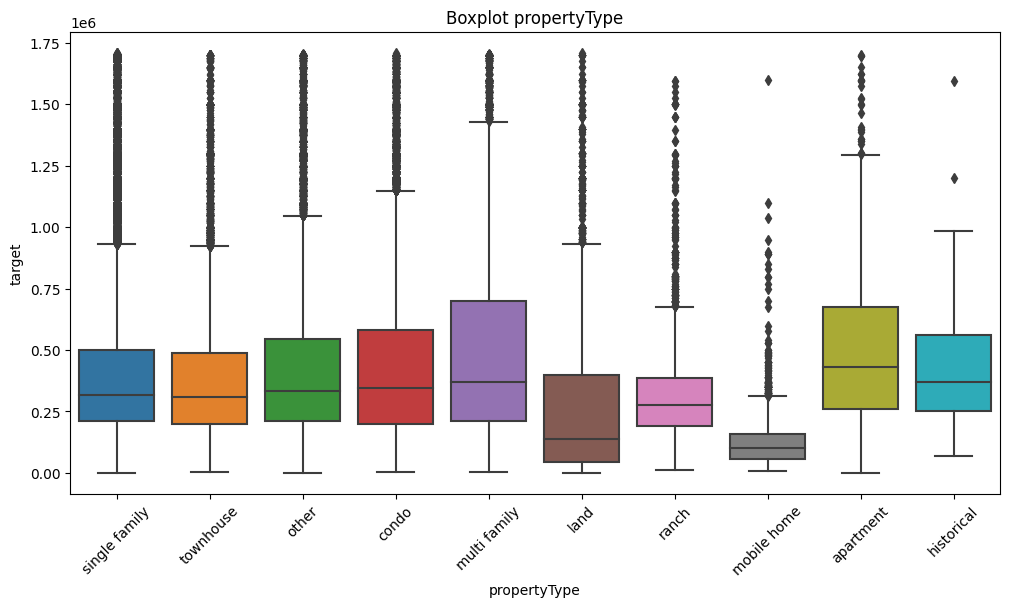

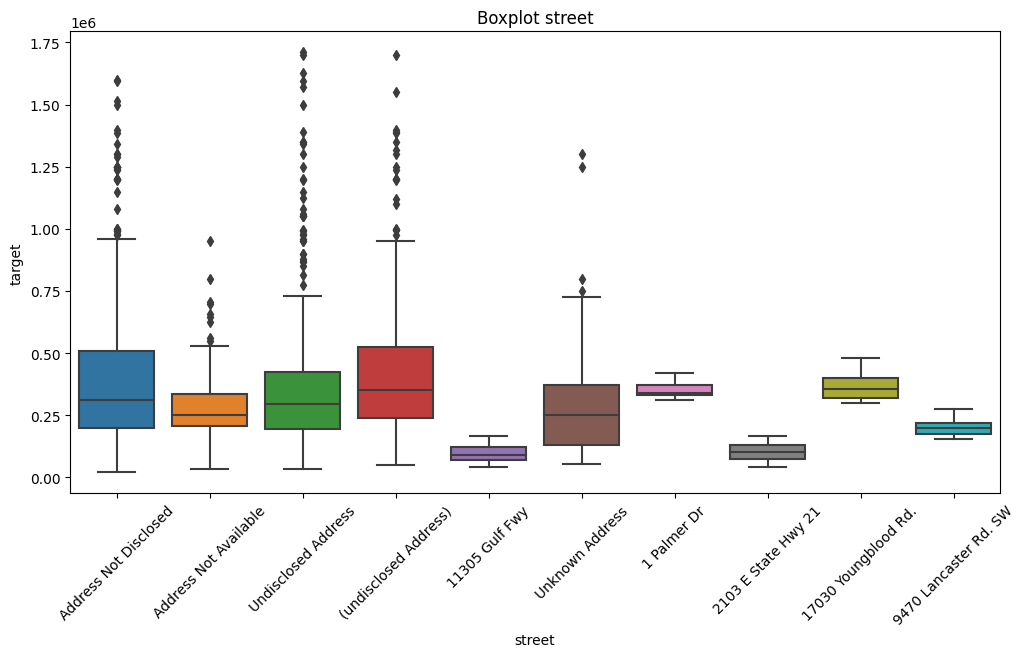

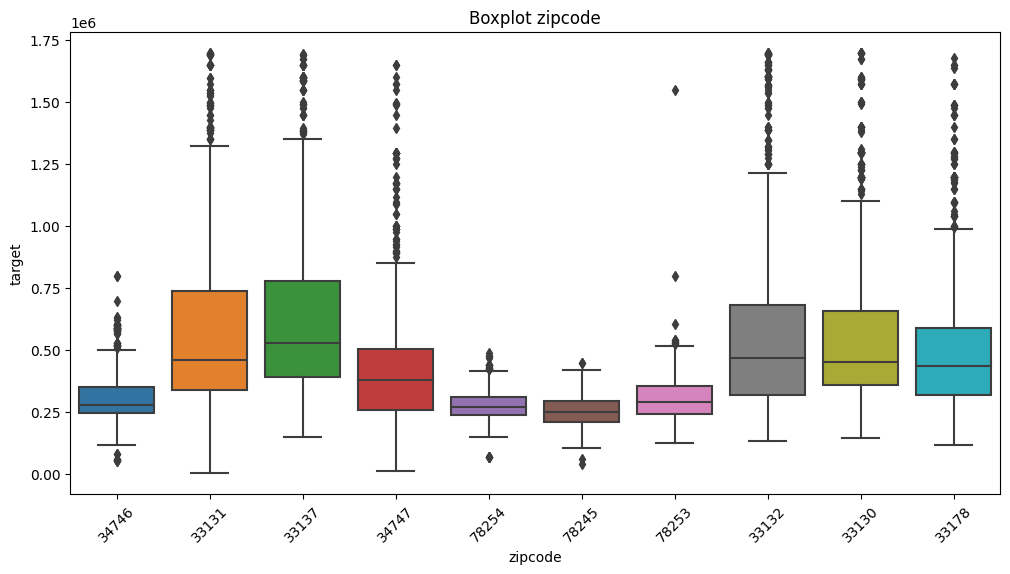

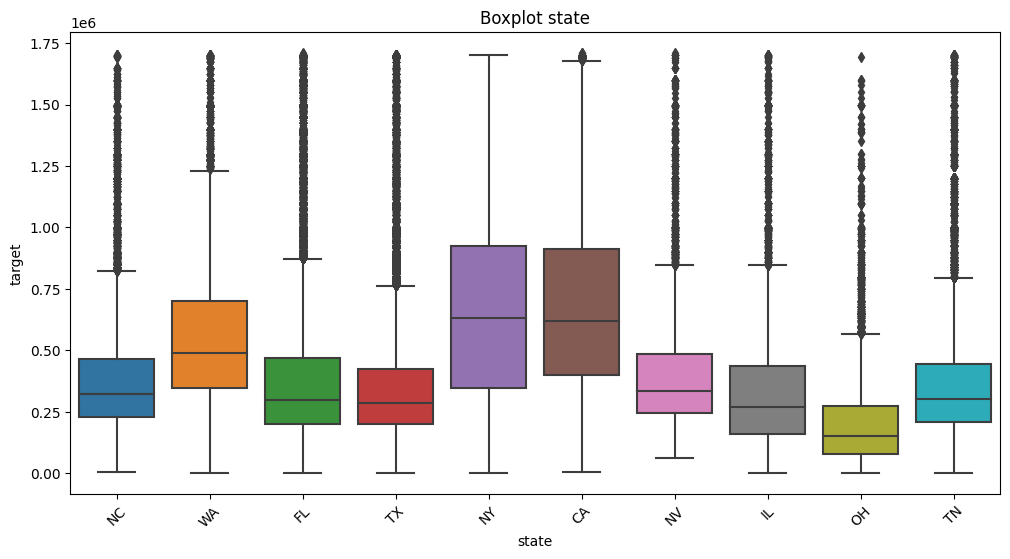

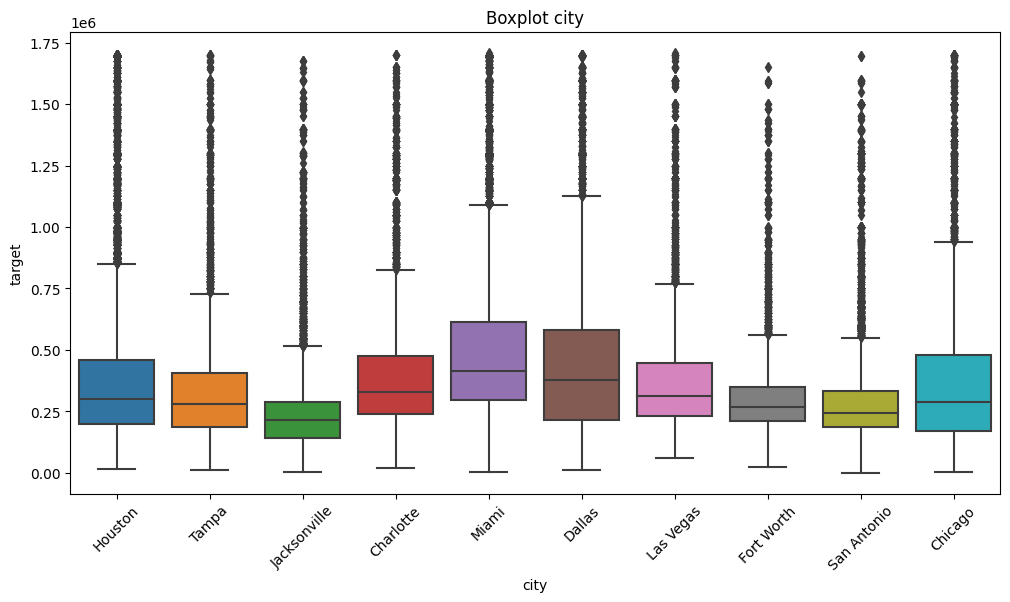

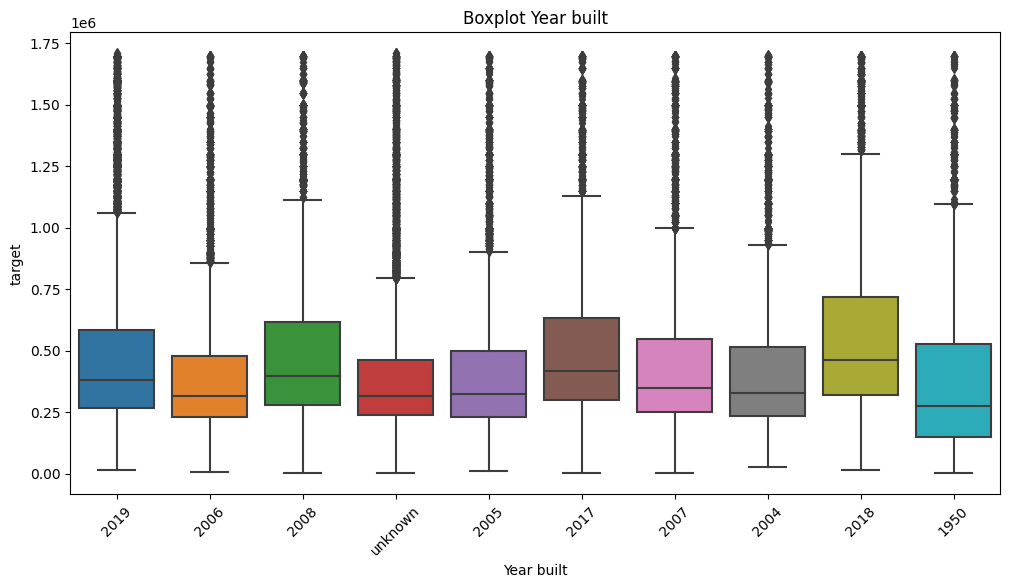

In [64]:
categor_features = ['status', 'propertyType', 'street', 'zipcode', 'state', 'city', 'Year built']
for cat in categor_features:
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=cat, y='target', data=df.loc[df.loc[:, cat].isin(df.loc[:, cat].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot ' + cat)
    plt.show()
    
    # Сохраним графики
    image_filename = os.path.join(output_directory, f'5_{cat}_plot.png')
    fig.savefig(image_filename)

## 3. Проектирование признаков

### 3.1 Оценка мультиколлинеарности

<Axes: >

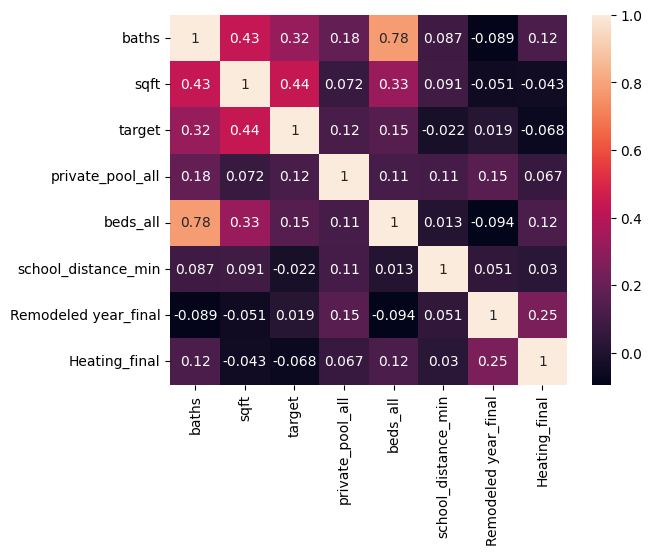

In [65]:
#df.info()
#df_headmap = df.drop('')
sns.heatmap(df.corr(numeric_only=True), annot = True)

На тепловой диаграимме мы наблюдаем сильную коллениарность двух признаков это bath и beds_all. Отсавим признак beds_all, а bath  удалим.

In [66]:
df = df.drop('baths', axis=1)

### 3.2. Нормализация данных
Произведем нормализацию данных способом MinMaxScale 

In [70]:
# Создайте объект MinMaxScaler
#scaler = MinMaxScaler()

# Выберите столбцы для нормализации
col_names = ['sqft', 'beds_all', 'school_distance_min', 'target']

# Произведите нормализацию и преобразуйте данные обратно в DataFrame
#df[col_names] = scaler.fit_transform(df[col_names])

In [68]:
# посмотрим по графикам как изменилось распределение признаков после нормализации
#fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
#ax1.set_title('После нормализации MinMaxScaler')

#sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
#sns.kdeplot(df['beds_all'], ax=ax1, label='beds_all')
#sns.kdeplot(df['schools_rating'], ax=ax1, label='schools_rating')
#sns.kdeplot(df['school_distance_min'], ax=ax1, label='school_distance_min')
#sns.kdeplot(df['target'], ax=ax1, label='target')
#ax1.legend()
# сохраним график
#plt.savefig("graphics/6_MinMaxScaler.png")
#plt.show()


Нормализация данных распределение MinMaxScaler не принесла желаемого результата. (оставим эти расчеты как черновые на всякий случай) <br>
Используем метот логарифмирования данных.


In [72]:
# Логарифмируем
for col in col_names:
        df[col] = df[col].apply(lambda x: abs(x))
        constant = 1e-6
        df[col] = np.log(df[col] + constant)
df

,status,propertyType,street,city,sqft,zipcode,state,target,private_pool_all,beds_all,school_distance_min,Year built,Remodeled year_final,Heating_final
0,Active,single family,240 Heather Ln,Southern Pines,2.075994,28387,NC,2.560573,False,0.326635,-0.006770,2019,False,True
1,For sale,single family,12911 E Heroy Ave,Spokane Valley,2.024727,99216,WA,2.537209,False,0.094049,-4.609949,2019,False,False
5,For sale,townhouse,1624 S Newkirk St,Philadelphia,1.916784,19145,PA,2.505533,False,-0.366511,-13.122364,1920,False,True
6,Active,other,552 Casanova Ct,POINCIANA,1.990320,34759,FL,2.493950,False,2.625792,-1.499941,2006,True,True
9,unknown,single family,8612 Cedar Plains Ln,Houston,2.023569,77080,TX,2.537716,False,0.094049,-0.671728,2019,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374244,unknown,single family,20800 NE 23rd Ave,Miami,2.116050,33180,FL,2.641758,True,0.475886,-2.350599,1990,True,True
374245,For sale,condo,3530 N Lake Shore Dr #4B,Chicago,2.028267,60657,IL,2.596930,False,0.094049,-0.087423,1924,False,True
374246,For sale,single family,15509 Linden Blvd,Jamaica,1.952922,11434,NY,2.578462,False,0.094049,-0.309290,1950,True,True
374247,unknown,other,7810 Pereida St,Houston,2.202251,77028,TX,2.346479,False,2.625792,-0.366514,unknown,False,False


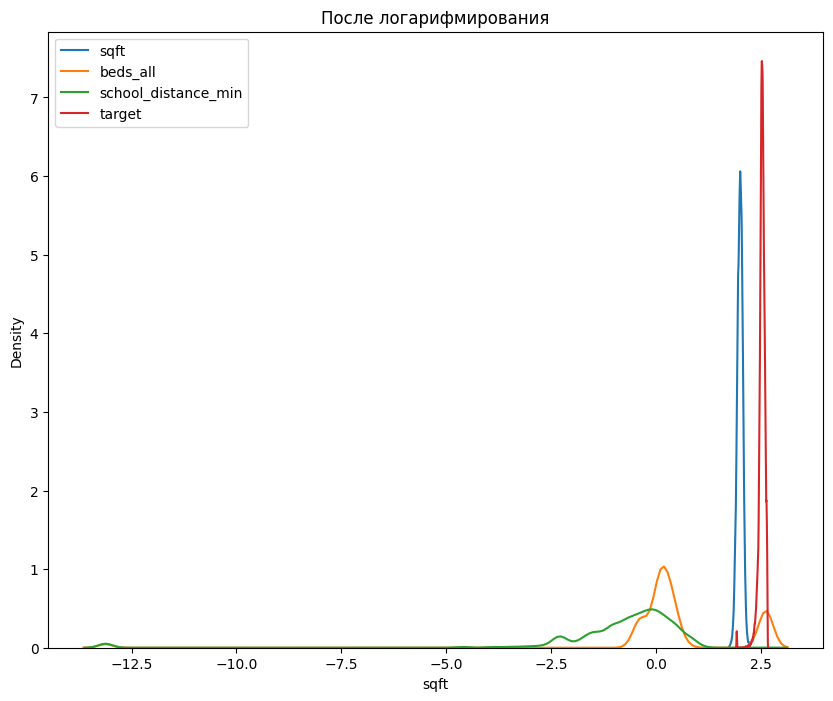

In [73]:
# Строим график после логарифмирования
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После логарифмирования')

sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df['beds_all'], ax=ax1, label='beds_all')
sns.kdeplot(df['school_distance_min'], ax=ax1, label='school_distance_min')
sns.kdeplot(df['target'], ax=ax1, label='target')
ax1.legend()

# Сохраняем график
plt.savefig("graphics/6_log.png")
plt.show()

## ДОПОЛНЕНИЕ ПОСЛЕ МОДЕЛИРОВАНИЯ

In [74]:
# Сохраним обработанные данные в CSV-файл для работы в CatBoost без кодировки категориальных признаков
df.to_csv(r"D:\Diplom\cleaned_data_for_CB.csv", index=False)

Cчитаем файл с данными для продолжения работы.

In [75]:
df = pd.read_csv(r"D:\Diplom\cleaned_data_for_CB.csv")
df.head(8)

,status,propertyType,street,city,sqft,zipcode,state,target,private_pool_all,beds_all,school_distance_min,Year built,Remodeled year_final,Heating_final
0,Active,single family,240 Heather Ln,Southern Pines,2.075994,28387,NC,2.560573,False,0.326635,-0.006770,2019,False,True
1,For sale,single family,12911 E Heroy Ave,Spokane Valley,2.024727,99216,WA,2.537209,False,0.094049,-4.609949,2019,False,False
2,For sale,townhouse,1624 S Newkirk St,Philadelphia,1.916784,19145,PA,2.505533,False,-0.366511,-13.122364,1920,False,True
3,Active,other,552 Casanova Ct,POINCIANA,1.990320,34759,FL,2.493950,False,2.625792,-1.499941,2006,True,True
4,unknown,single family,8612 Cedar Plains Ln,Houston,2.023569,77080,TX,2.537716,False,0.094049,-0.671728,2019,False,True
5,For sale,condo,14205 Roosevelt Ave #512,Flushing,1.969922,11354,NY,2.596265,False,0.094049,0.185625,1965,False,False
6,Active,other,4222 False Cypress Ln,Houston,2.085522,77068,TX,2.523200,False,2.625792,-0.087423,2015,True,True
7,For sale,single family,16373 NW 16th St,Pembroke Pines,2.073324,33028,FL,2.578029,True,0.326635,-2.484329,1996,True,True


### 3.3. Кодирование признаков

In [76]:
df.describe(include = 'object')

,status,propertyType,street,city,state,Year built
count,283620,283620,283620,283620,283620,283620
unique,13,11,252821,1641,36,212
top,For sale,single family,Address Not Disclosed,Houston,FL,2019
freq,160157,165857,552,21157,82657,26824


Удаляем столбец street, т.к. он содержит слишком много уникальных значений и дублирует информацию по городу и признаку<br>

In [77]:
df = df.drop('street', axis=1)

 Произведем однократное кодирование OneHotEncoder слобцов: status, propertyType

In [78]:
df_encoded = pd.get_dummies(df, columns=['status', 'propertyType'])
df_encoded.head(8)

,city,sqft,zipcode,state,target,private_pool_all,beds_all,school_distance_min,Year built,Remodeled year_final,...,propertyType_condo,propertyType_historical,propertyType_land,propertyType_mobile home,propertyType_multi family,propertyType_other,propertyType_ranch,propertyType_single family,propertyType_townhouse,propertyType_unknown
0,Southern Pines,2.075994,28387,NC,2.560573,False,0.326635,-0.006770,2019,False,...,False,False,False,False,False,False,False,True,False,False
1,Spokane Valley,2.024727,99216,WA,2.537209,False,0.094049,-4.609949,2019,False,...,False,False,False,False,False,False,False,True,False,False
2,Philadelphia,1.916784,19145,PA,2.505533,False,-0.366511,-13.122364,1920,False,...,False,False,False,False,False,False,False,False,True,False
3,POINCIANA,1.990320,34759,FL,2.493950,False,2.625792,-1.499941,2006,True,...,False,False,False,False,False,True,False,False,False,False
4,Houston,2.023569,77080,TX,2.537716,False,0.094049,-0.671728,2019,False,...,False,False,False,False,False,False,False,True,False,False
5,Flushing,1.969922,11354,NY,2.596265,False,0.094049,0.185625,1965,False,...,True,False,False,False,False,False,False,False,False,False
6,Houston,2.085522,77068,TX,2.523200,False,2.625792,-0.087423,2015,True,...,False,False,False,False,False,True,False,False,False,False
7,Pembroke Pines,2.073324,33028,FL,2.578029,True,0.326635,-2.484329,1996,True,...,False,False,False,False,False,False,False,True,False,False



Оставшиеся столбцы кодируем LabelEncoder (city, zipcode, state, Year built)<br>

In [79]:
state_le = LabelEncoder()
state_label = state_le.fit_transform(df_encoded['state'])
df_encoded['state_label'] = state_label

yearb_le = LabelEncoder()
yearb_label = yearb_le.fit_transform(df_encoded['Year built'])
df_encoded['year_label'] = yearb_label

city_le = LabelEncoder()
city_label = city_le.fit_transform(df_encoded['city'])
df_encoded['city_label'] = city_label

zipcode_le = LabelEncoder()
zipcode_label = zipcode_le.fit_transform(df_encoded['zipcode'])
df_encoded['zipcode_label'] = zipcode_label

# Удалим обработанные столбцы
df_encoded.drop(['state', 'city', 'zipcode','Year built'], axis=1, inplace=True)

In [80]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283620 entries, 0 to 283619
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sqft                        283620 non-null  float64
 1   target                      283620 non-null  float64
 2   private_pool_all            283620 non-null  bool   
 3   beds_all                    283620 non-null  float64
 4   school_distance_min         283620 non-null  float64
 5   Remodeled year_final        283620 non-null  bool   
 6   Heating_final               283620 non-null  bool   
 7   status_Active               283620 non-null  bool   
 8   status_Auction              283620 non-null  bool   
 9   status_Back on market       283620 non-null  bool   
 10  status_Closed               283620 non-null  bool   
 11  status_Coming soon          283620 non-null  bool   
 12  status_Contingent           283620 non-null  bool   
 13  status_For ren

In [81]:
# Cохраняем данные в CSV-файл для упрощения дальнейшей работы
df_encoded.to_csv(r"D:\Diplom\cleaned_data_for_model.csv", index=False)

## *Выводы по второй и третьей частям работы:*
- проверили взаимосвязи между признаками и таргетом
- обработали и преобразовали числовые признаки, нашли и удалили выбросы методом Тьюки
- обработали и преобразовали категориальные признаки
- провели анализ на мультиколлениарность
- выполнили логарифмирование признаков
- выполнили кодирование признаков
- сохранили файл в CSV-файл для дальнейшей работы при подборе модели и прогнозировании